# CPU

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.63MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.55MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.47MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

54.00699057413737
45.30402793579101
43.39048732910156
42.25717751464844
41.56446864827474
41.029518131510414
40.660392443847655
40.38718920694987
40.159646185302734
39.972681561279295
39.8271286722819
39.670247300211585
39.564336694335935
39.49526638590495
39.394126959228515
39.3177494547526
39.25062006022135
39.15506819051107
39.13526733194987
39.07614185180664
38.959267087809245
38.91027748413086
38.88209548543294
38.836680446370444
38.812767899576826
38.755121413167316
38.71043398844401
38.70568516235352
38.64828127441406
38.635535447184246


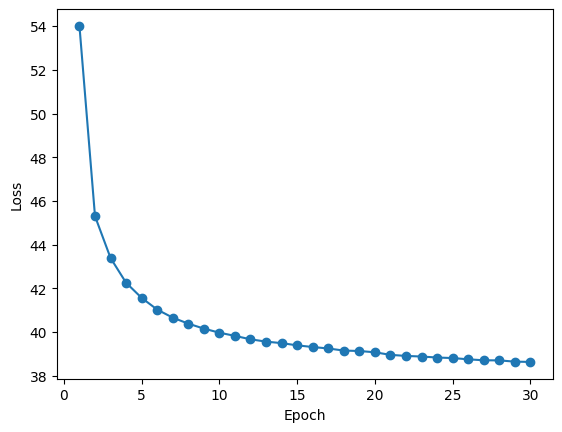

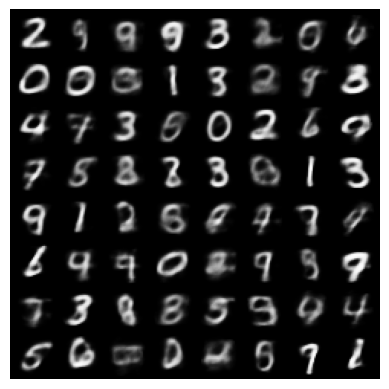

In [1]:
# 필요한 라이브러리 임포트
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms


# 하이퍼파라미터 설정
input_dim = 784  # 입력 차원 (MNIST 이미지: 28x28 = 784)
hidden_dim = 200  # 은닉층의 뉴런 수
latent_dim = 20  # 잠재 변수 z의 차원
epochs = 30  # 학습 에포크 수
learning_rate = 3e-4  # 학습률
batch_size = 32  # 배치 크기


# 인코더 클래스 정의
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)  # 입력층 -> 은닉층
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)  # 은닉층 -> 평균
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)  # 은닉층 -> 로그분산

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)  # ReLU 활성화 함수
        mu = self.linear_mu(h)  # 평균값 계산
        logvar = self.linear_logvar(h)  # 로그분산 계산
        sigma = torch.exp(0.5 * logvar)  # 표준편차 계산
        return mu, sigma


# 디코더 클래스 정의
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)  # 잠재변수 -> 은닉층
        self.linear2 = nn.Linear(hidden_dim, output_dim)  # 은닉층 -> 출력층

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)  # ReLU 활성화 함수
        h = self.linear2(h)
        x_hat = F.sigmoid(h)  # 시그모이드 활성화 함수 (픽셀값 0~1)
        return x_hat


# 재매개변수화 트릭 구현
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)  # 표준 정규분포에서 노이즈 샘플링
    z = mu + eps * sigma  # 재매개변수화 트릭
    return z


# VAE(Variational AutoEncoder) 클래스 정의
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)  # 인코딩
        z = reparameterize(mu, sigma)  # 잠재 변수 샘플링
        x_hat = self.decoder(z)  # 디코딩

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')  # 재구성 손실
        L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)  # KL 발산
        return (L1 + L2) / batch_size  # 전체 손실 함수


# 데이터셋 준비
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten)  # 2D 이미지를 1D로 평탄화
            ])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델 및 옵티마이저 초기화
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

# 학습 루프
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()  # 그래디언트 초기화
        loss = model.get_loss(x)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt  # 에포크당 평균 손실
    print(loss_avg)
    losses.append(loss_avg)

# 손실 그래프 그리기
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# 새로운 이미지 생성
with torch.no_grad():
    sample_size = 64  # 생성할 이미지 개수
    z = torch.randn(sample_size, latent_dim)  # 잠재 공간에서 랜덤 샘플링
    x = model.decoder(z)  # 디코딩하여 이미지 생성
    generated_images = x.view(sample_size, 1, 28, 28)  # 텐서 형태 변환

# 생성된 이미지 시각화
grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

# GPU

Using device: cuda
Epoch [1/30], Loss: 54.0281
Epoch [2/30], Loss: 45.2696
Epoch [3/30], Loss: 43.5090
Epoch [4/30], Loss: 42.3243
Epoch [5/30], Loss: 41.5315
Epoch [6/30], Loss: 41.0376
Epoch [7/30], Loss: 40.6976
Epoch [8/30], Loss: 40.4640
Epoch [9/30], Loss: 40.2670
Epoch [10/30], Loss: 40.1027
Epoch [11/30], Loss: 39.9660
Epoch [12/30], Loss: 39.7889
Epoch [13/30], Loss: 39.6920
Epoch [14/30], Loss: 39.6138
Epoch [15/30], Loss: 39.5220
Epoch [16/30], Loss: 39.4239
Epoch [17/30], Loss: 39.3976
Epoch [18/30], Loss: 39.3121
Epoch [19/30], Loss: 39.1971
Epoch [20/30], Loss: 39.2069
Epoch [21/30], Loss: 39.1028
Epoch [22/30], Loss: 39.0784
Epoch [23/30], Loss: 38.9996
Epoch [24/30], Loss: 39.0062
Epoch [25/30], Loss: 38.9180
Epoch [26/30], Loss: 38.9022
Epoch [27/30], Loss: 38.8496
Epoch [28/30], Loss: 38.7960
Epoch [29/30], Loss: 38.7548
Epoch [30/30], Loss: 38.7394


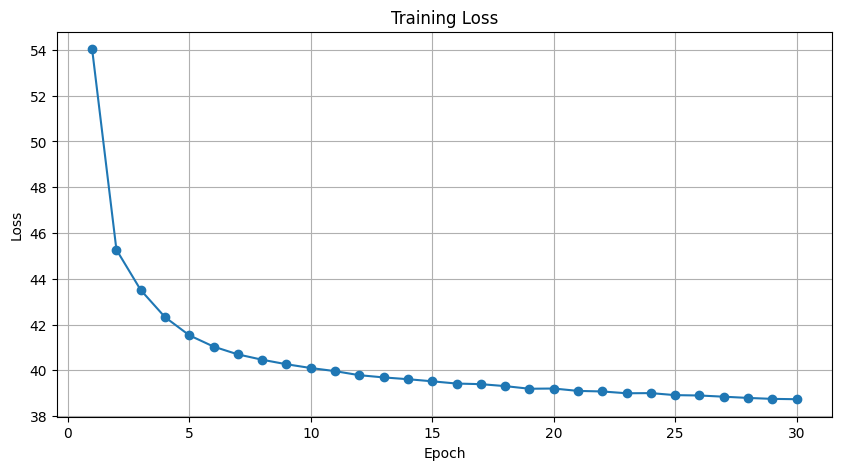

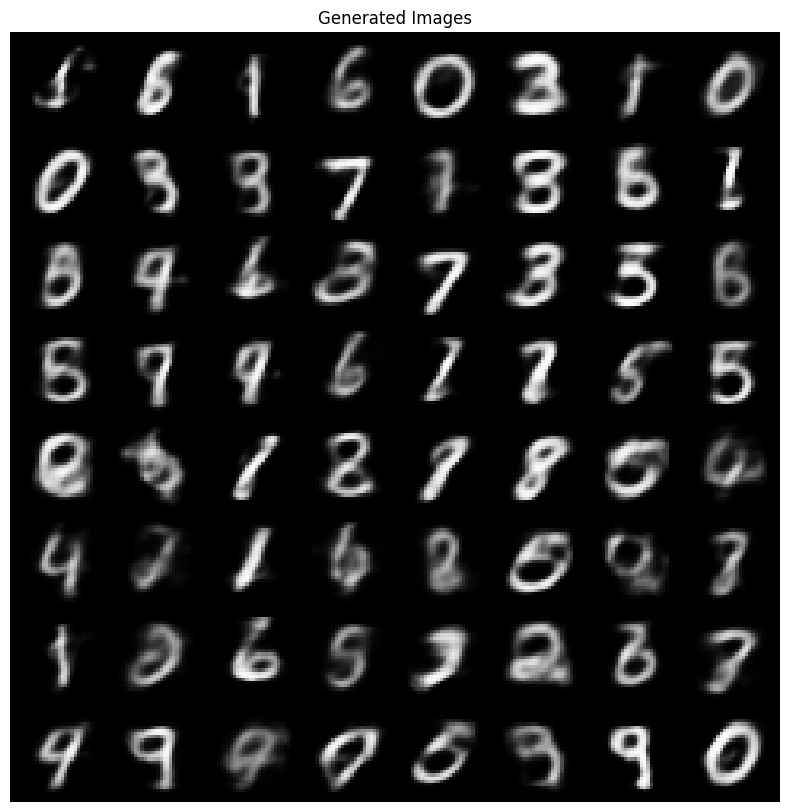

In [2]:
# 필요한 라이브러리 임포트
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 하이퍼파라미터 설정
input_dim = 784  # 입력 차원 (MNIST 이미지: 28x28 = 784)
hidden_dim = 200  # 은닉층의 뉴런 수
latent_dim = 20  # 잠재 변수 z의 차원
epochs = 30  # 학습 에포크 수
learning_rate = 3e-4  # 학습률
batch_size = 32  # 배치 크기

# 인코더 클래스 정의
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma

# 디코더 클래스 정의
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat

# 재매개변수화 트릭 구현
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z

# VAE 클래스 정의
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batch_size

# 데이터셋 준비
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델 및 옵티마이저 초기화
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

# 학습 루프
for epoch in range(epochs):
    model.train()  # 학습 모드로 설정
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        x = x.to(device)  # 데이터를 GPU로 이동
        
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss_avg:.4f}')
    losses.append(loss_avg)

# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# 새로운 이미지 생성
model.eval()  # 평가 모드로 설정
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim).to(device)  # GPU에서 랜덤 샘플링
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28).cpu()  # CPU로 이동하여 시각화

# 생성된 이미지 시각화
plt.figure(figsize=(10, 10))
grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.title('Generated Images')
plt.show()